# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [4]:
def compute_distance(x, y):

    distance = np.sqrt(x**2 + y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # Predict the SNR from a given model

    DistArr = [distance**a for a in range(len(poly_coeffs))]

    SNR = np.dot(DistArr, poly_coeffs[::-1])
    
    return SNR

def evaluate(distance, SNR, poly_coeffs):
    
    Predict = np.array([predict(dist, poly_coeffs) for dist in distance])

    mse = np.sum((Predict - SNR)**2)/len(distance)

    return mse

def separate_test(distance, SNR, test_points):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly

    idx = np.arange(len(distance))

    test_idx = np.random.choice(idx, test_points, replace=False)

    train_idx = [i for i in idx if i not in test_idx]

    x_train, y_train = distance[train_idx], SNR[train_idx]
    x_test, y_test = distance[test_idx], SNR[test_idx]


    return x_train, y_train, x_test, y_test


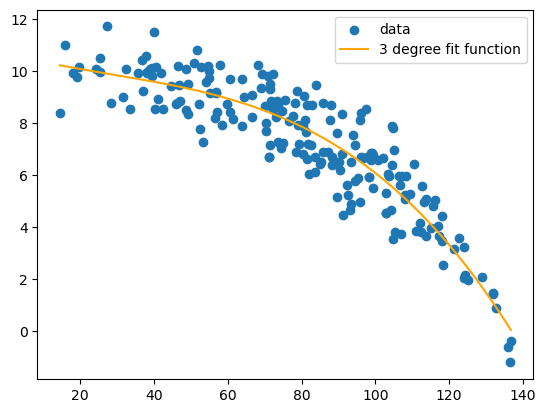

In [5]:
Dist = compute_distance(x, y)

x_train, y_train, x_test, y_test = separate_test(Dist, SNR, 40)

degree = 3
FitCoeff = fit(Dist, SNR, degree)
xFit = np.linspace(np.min(Dist), np.max(Dist), 200)
Predict = [predict(i, FitCoeff) for i in xFit]

mse = evaluate(Predict, SNR, FitCoeff)

plt.scatter(Dist, SNR, label='data')
plt.plot(xFit, Predict, color='orange', label=f'{degree} degree fit function')
plt.legend()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [6]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    results = []

    for deg in range(1, max_degree+1):

        ErrorForFold = []
        #Ensures that does not go above the number of train data
        #! IMPORTANT
        fracData = int(np.floor(len(x_train)/k))

        for i in range(k):

            #separate train into train and validation
            idx = np.arange(len(x_train))
            #! IMPORTANT
            valIdx = np.arange(fracData) + i*fracData

            trainIdx = [i for i in idx if i not in valIdx]
            
            xVal, yVal = x_train[valIdx], y_train[valIdx]
            xTrain, yTrain = x_train[trainIdx], y_train[trainIdx]

            FitCoeff = fit(xTrain, yTrain, deg)

            mse = evaluate(xVal, yVal, FitCoeff)

            ErrorForFold.append(mse)


        results.append(np.mean(ErrorForFold))

    bestDeg = np.argmin(results)+1
    bestRes = np.min(results)

    best = (bestRes, bestDeg)
        


    return best, results

(1.004600679191257, 3)


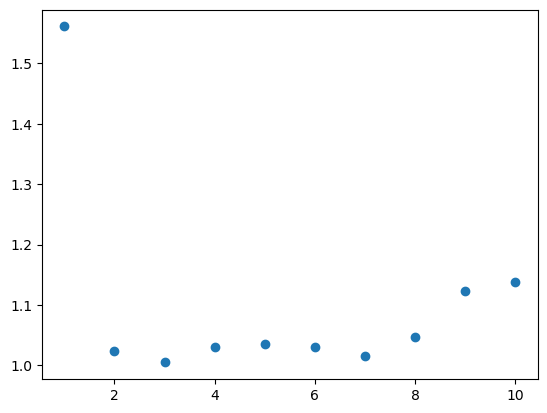

In [15]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree
x_train, y_train, x_test, y_test = separate_test(Dist, SNR, 40)

best, results = k_fold_cross_validation(x_train, y_train, 4, 10)
print(best)

plt.scatter(np.arange(1, 11), results)

In [81]:
print(results)

[1.6666402098553463, 1.0088083219790425, 0.9775232549482035, 0.9974579821441316, 1.0068216788800204, 1.006999499507363, 1.0194169020485193, 1.0220598415944986, 1.0759552622630952, 1.1087518407057124]


In [ ]:
# TODO: get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [17]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int, k = 4) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    results = []

    for deg in range(1, max_degree+1):

        ErrorForFold = []
        #Ensures that does not go above the number of train data
        #! IMPORTANT
        fracData = int(np.floor(len(x_train)/k))

        for i in range(k):

            #separate train into train and validation
            idx = np.arange(len(x_train))
            #! IMPORTANT
            valIdx = np.arange(fracData) + i*fracData

            trainIdx = [i for i in idx if i not in valIdx]
            
            xVal, yVal = x_train[valIdx], y_train[valIdx]
            xTrain, yTrain = x_train[trainIdx], y_train[trainIdx]

            FitCoeff = fit(xTrain, yTrain, deg)

            mse = evaluate(xVal, yVal, FitCoeff) + lambda_par*np.sum(FitCoeff**2)

            ErrorForFold.append(mse)


        results.append(np.mean(ErrorForFold))

    bestDeg = np.argmin(results)+1
    bestRes = np.min(results)

    best = (bestRes, bestDeg)

    return best, results

[3.2700678313121685, 1.8067757447016488, 2.1788622905359025, 1.947111954748941, 1.988789266744099]


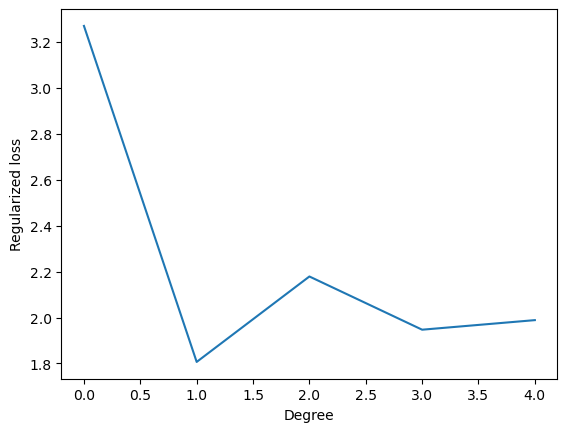

In [22]:
max_degree = 5
test_points = 40
lambda_par = 0.01

distance = compute_distance(x, y)
best_model_tkh, results = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
print(results)
plt.plot(range(max_degree), results)
plt.xlabel('Degree')
plt.ylabel('Regularized loss')
plt.show()

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [ ]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    return best, results

In [ ]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree

### TEST

Check the performance of the three solutions on the test set: which one does best?


In [ ]:
# TODO: plot the results